## Import libraries <a class="anchor" id="section_1.1"></a>

In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Import model libraries
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

# Suppress the warnings
import warnings
warnings.filterwarnings("ignore")

## Import data <a class="anchor" id="section_1.2"></a>

In [4]:
# Import the price data
df = pd.read_csv("./monthly_csv.csv")
df.head()

,Date,Price
0,1950-01,34.73
1,1950-02,34.73
2,1950-03,34.73
3,1950-04,34.73
4,1950-05,34.73


In [5]:
df.shape

(847, 2)

# Exploratory Data Analysis <a class="anchor" id="section2"></a>

## Understanding the data <a class="anchor" id="section2.1"></a>

In [6]:
print(f"Date range of gold prices available from - {df.loc[:,'Date'][0]} to {df.loc[:,'Date'][len(df)-1]}")

Date range of gold prices available from - 1950-01 to 2020-07


In [7]:
date = pd.date_range(start='1/1/1950', end='8/1/2020', freq='M')
date

DatetimeIndex(['1950-01-31', '1950-02-28', '1950-03-31', '1950-04-30',
               '1950-05-31', '1950-06-30', '1950-07-31', '1950-08-31',
               '1950-09-30', '1950-10-31',
               ...
               '2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31',
               '2020-02-29', '2020-03-31', '2020-04-30', '2020-05-31',
               '2020-06-30', '2020-07-31'],
              dtype='datetime64[ns]', length=847, freq='M')

In [8]:
df['month'] = date
df.drop('Date',axis=1,inplace=True)
df = df.set_index('month')
df.head()

,Price
month,
1950-01-31,34.73
1950-02-28,34.73
1950-03-31,34.73
1950-04-30,34.73
1950-05-31,34.73


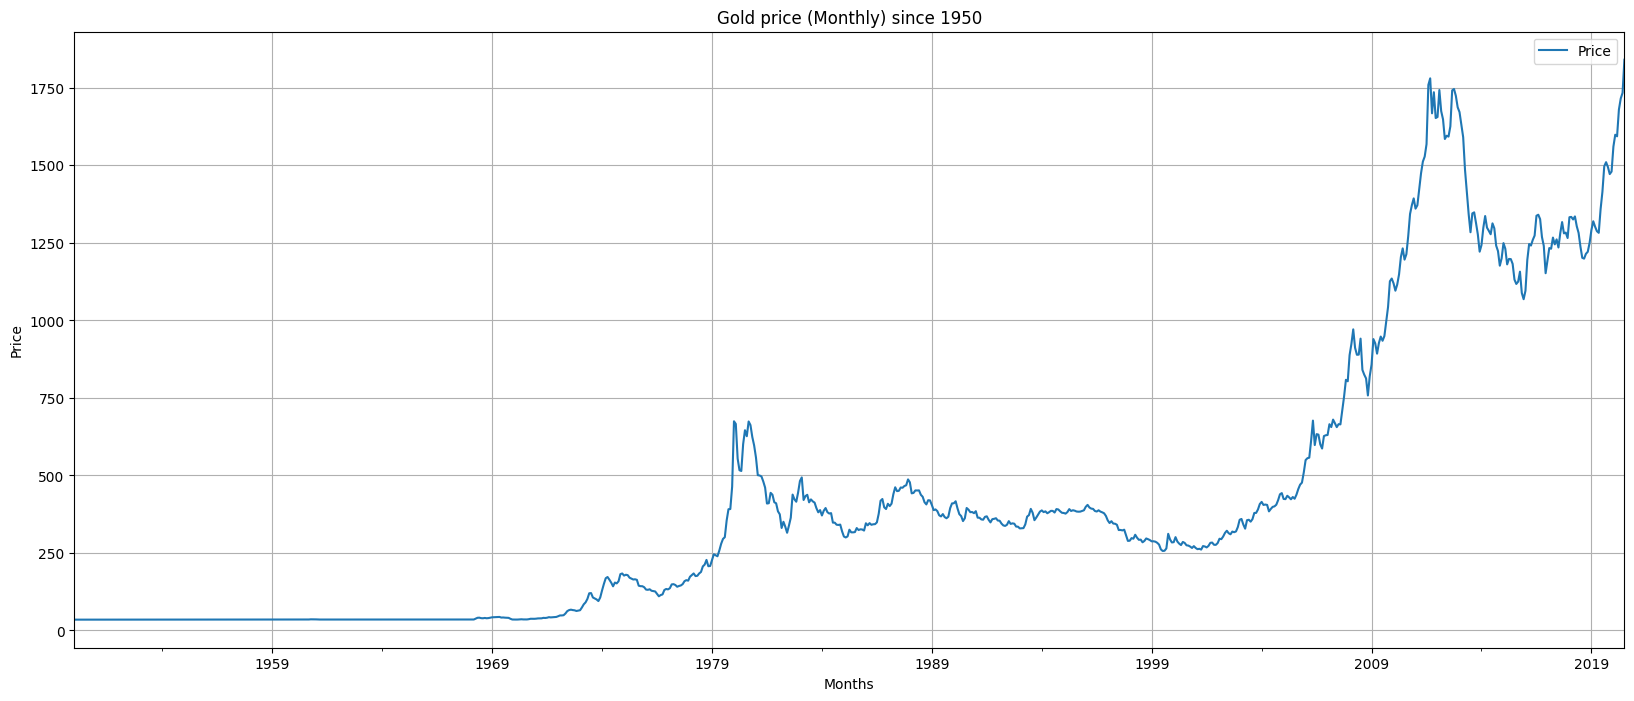

In [9]:
df.plot(figsize=(20,8))
plt.title("Gold price (Monthly) since 1950")
plt.xlabel("Months")
plt.ylabel("Price")
plt.grid();

In [10]:
round(df.describe(),3)

,Price
count,847.000
mean,416.557
std,453.665
min,34.490
25%,35.190
50%,319.622
75%,447.029
max,1840.807


**Inference**

1. The Average gold price in last 70 years is **$416.56**

2. **Only 25% of the time**, the gold price is above **$447.07**

3. Highest Gold price ever touched is **$1840.81**

## Visual Analysis <a class="anchor" id="section2.2"></a>

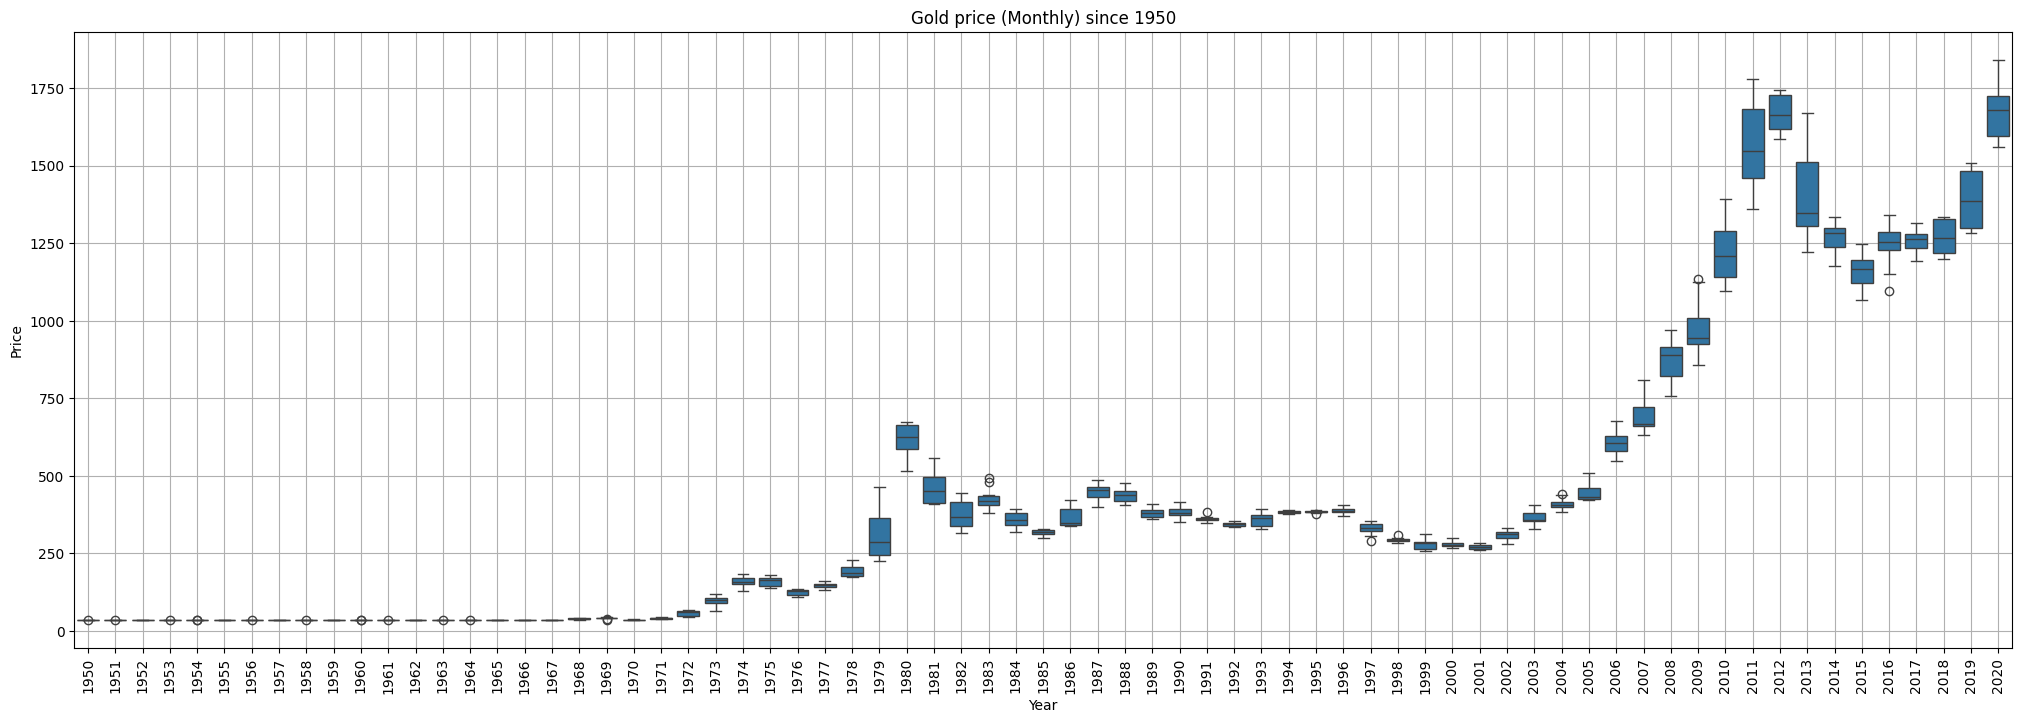

In [11]:
_, ax = plt.subplots(figsize=(25,8))
sns.boxplot(x = df.index.year,y = df.values[:,0],ax=ax)
plt.title("Gold price (Monthly) since 1950")
plt.xlabel("Year")
plt.ylabel("Price")
plt.xticks(rotation=90)
plt.grid();

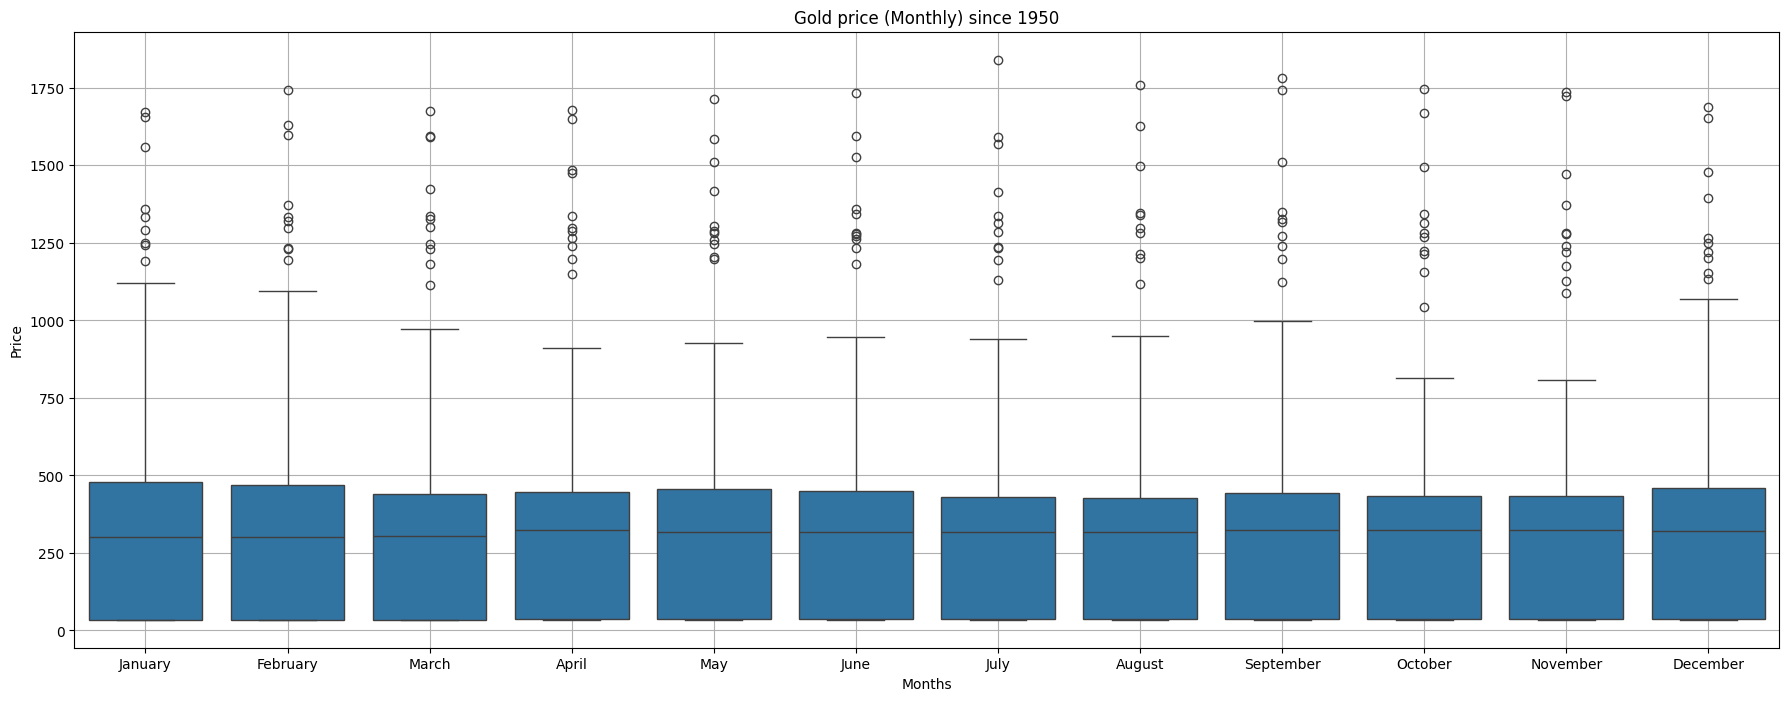

In [12]:
_, ax = plt.subplots(figsize=(22,8))
sns.boxplot(x = df.index.month_name(),y = df.values[:,0],ax=ax)
plt.title("Gold price (Monthly) since 1950")
plt.xlabel("Months")
plt.ylabel("Price")
plt.grid();

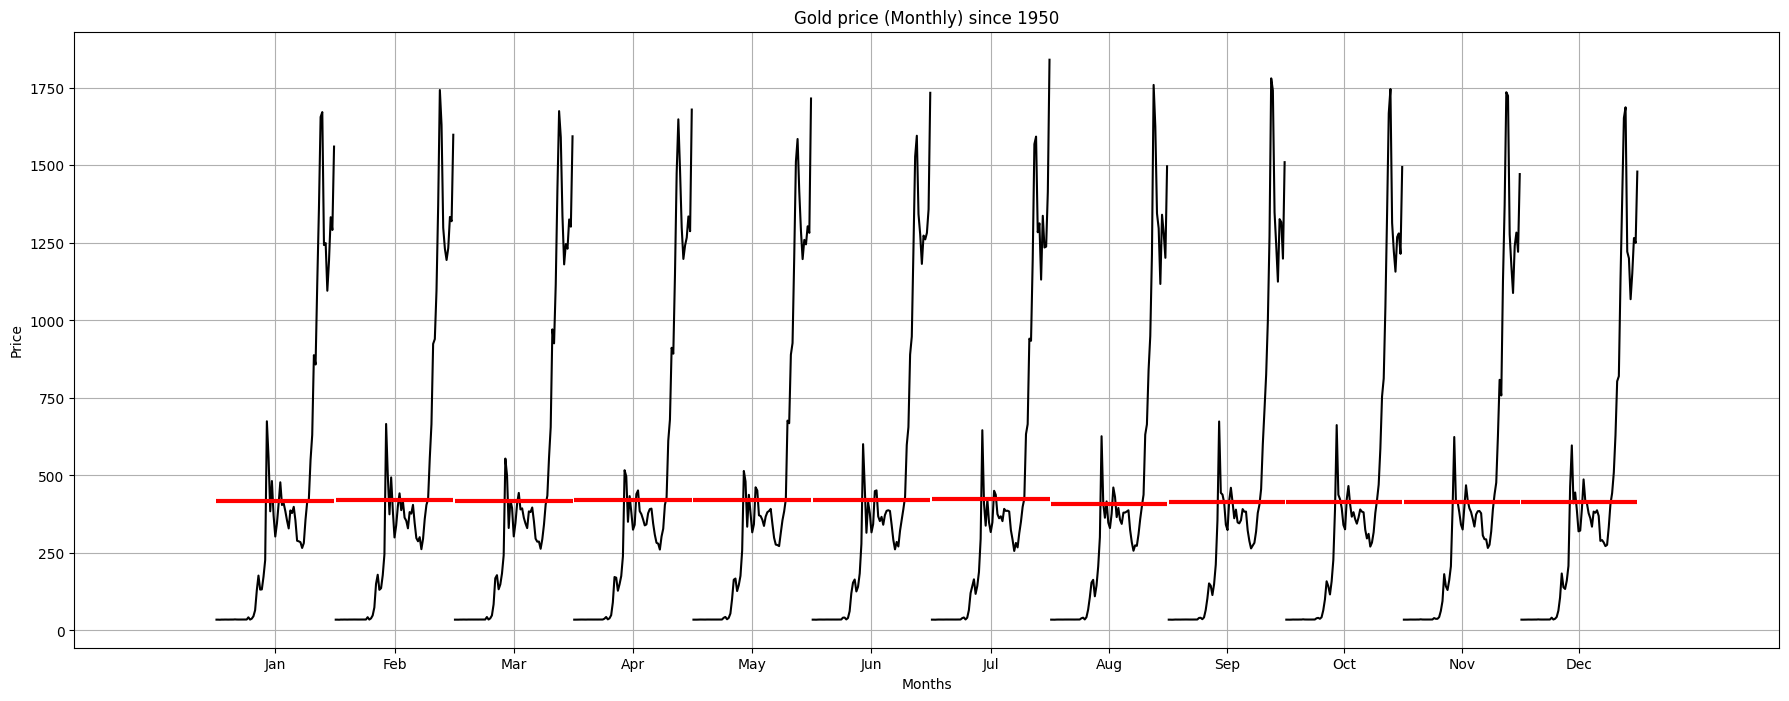

In [13]:
from statsmodels.graphics.tsaplots import month_plot

fig, ax = plt.subplots(figsize=(22,8))

month_plot(df,ylabel='Gold price',ax=ax)
plt.title("Gold price (Monthly) since 1950")
plt.xlabel("Months")
plt.ylabel("Price")
plt.grid();

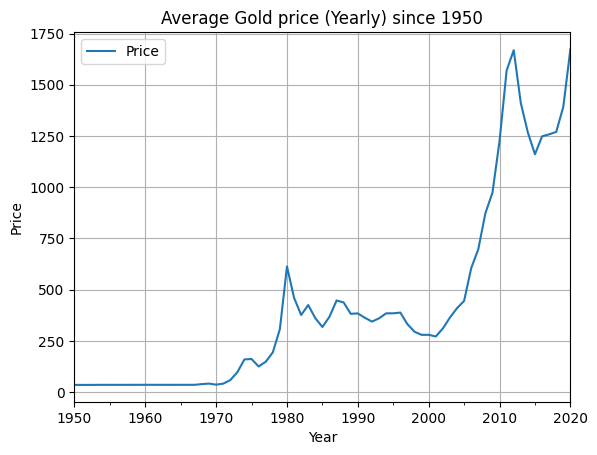

In [14]:
# Average gold price per year trend since 1950
df_yearly_sum = df.resample('A').mean()
df_yearly_sum.plot();
plt.title("Average Gold price (Yearly) since 1950")
plt.xlabel("Year")
plt.ylabel("Price")
plt.grid()

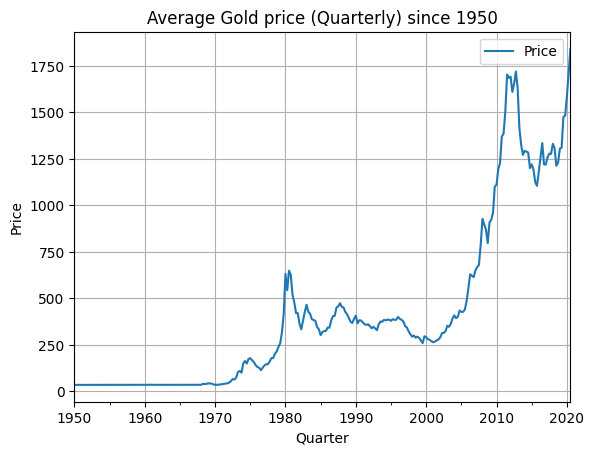

In [15]:
# Average gold price per quarter trend since 1950
df_quarterly_sum = df.resample('Q').mean()
df_quarterly_sum.plot();
plt.title("Average Gold price (Quarterly) since 1950")
plt.xlabel("Quarter")
plt.ylabel("Price")
plt.grid()

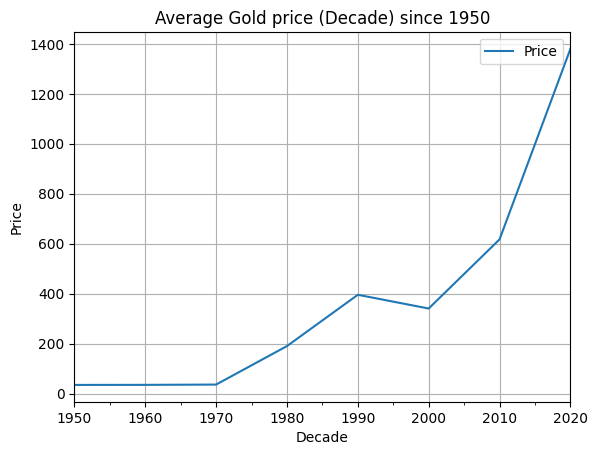

In [16]:
# Average gold price per decade trend since 1950
df_decade_sum = df.resample('10Y').mean()
df_decade_sum.plot();
plt.title("Average Gold price (Decade) since 1950")
plt.xlabel("Decade")
plt.ylabel("Price")
plt.grid()

### Analysis in Coefficient of variation

1. The coefficient of variation (CV) is a statistical measure of the relative dispersion of data points in a data series around the mean.
2. In finance, the coefficient of variation allows investors to determine how much volatility, or risk, is assumed in comparison to the amount of return expected from investments.
3. The lower the ratio of the standard deviation to mean return, the better risk-return trade-off.

Let us look at the CV values for each year in Gold price

In [17]:
# Coefficient of variation in price
df_1 = df.groupby(df.index.year).mean().rename(columns={'Price':'Mean'})
df_1 = df_1.merge(df.groupby(df.index.year).std().rename(columns={'Price':'Std'}),left_index=True,right_index=True)
df_1['CoV_pct'] = ((df_1['Std']/df_1['Mean'])*100).round(2)
df_1.head()

,Mean,Std,CoV_pct
month,,,
1950,34.729167,0.002887,0.01
1951,34.717500,0.020057,0.06
1952,34.628333,0.117538,0.34
1953,34.879167,0.056481,0.16
1954,35.020000,0.082792,0.24


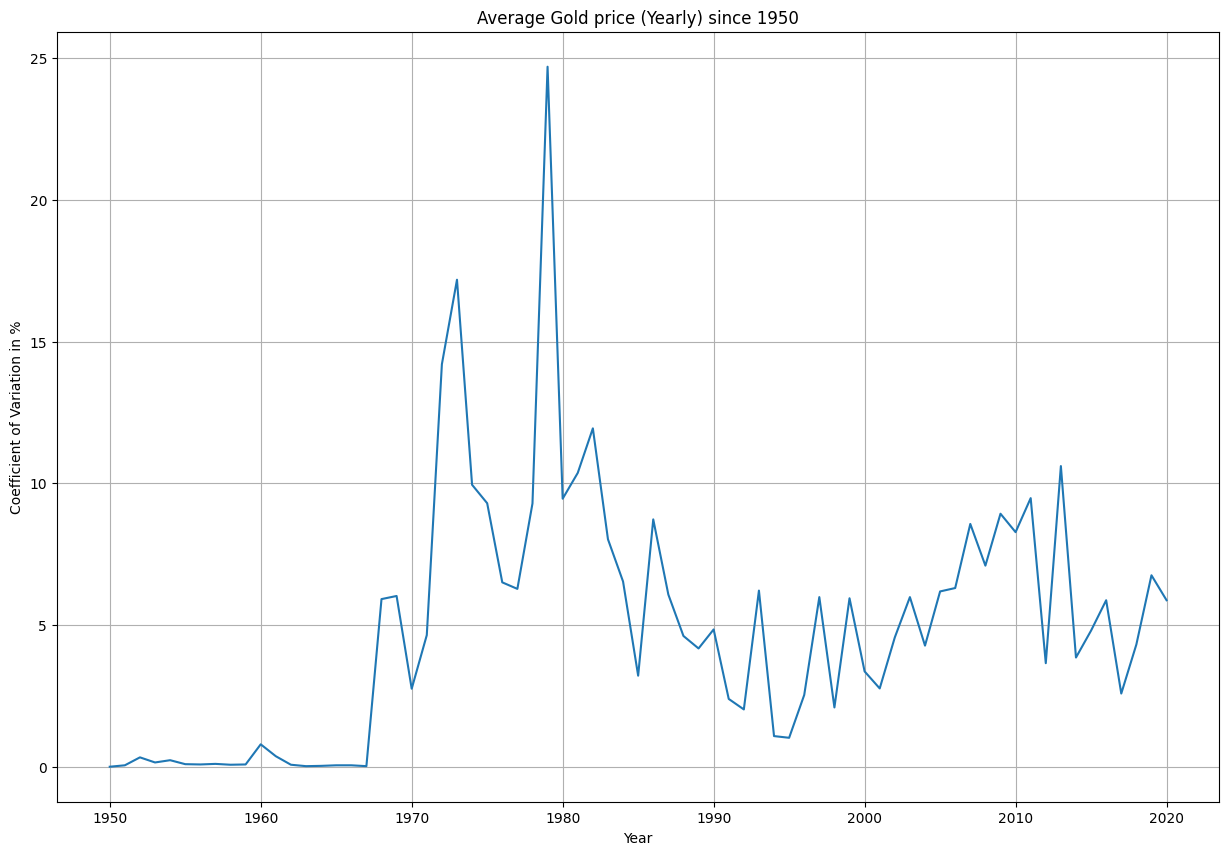

In [18]:
# Average gold price per year trend since 1950
fig, ax = plt.subplots(figsize=(15,10))
df_1['CoV_pct'].plot();
plt.title("Average Gold price (Yearly) since 1950")
plt.xlabel("Year")
plt.ylabel("Coefficient of Variation in %")
plt.grid()

**Inference**

1. The CV value reached its highest in year 1978 near to 25%, which could have made the asset as highly risky
2. But in 2020, the CV value is closer to 5%, which makes the asset viable for good investment

# Time Series - Forecasting models <a class="anchor" id="section3"></a>

## Train - Test split to build Time series forecasting models <a class="anchor" id="section3.1"></a>

In [19]:
train    =   df[df.index.year <= 2015] 
test     =   df[df.index.year > 2015]

In [20]:
print(train.shape)
print(test.shape)

(792, 1)
(55, 1)


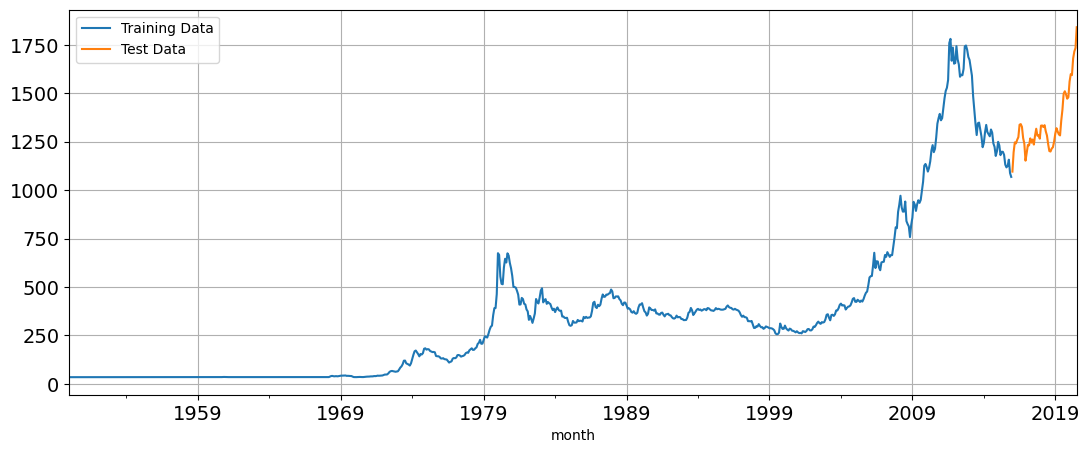

In [21]:
train['Price'].plot(figsize=(13,5), fontsize=14)
test['Price'].plot(figsize=(13,5), fontsize=14)
plt.grid()
plt.legend(['Training Data','Test Data'])
plt.show()

## Model 1 - Linear Regression <a class="anchor" id="section3.2"></a>

In [22]:
train_time = [i+1 for i in range(len(train))]
test_time = [i+len(train)+1 for i in range(len(test))]
len(train_time), len(test_time)

(792, 55)

In [23]:
LR_train = train.copy()
LR_test = test.copy()

In [24]:
LR_train['time'] = train_time
LR_test['time'] = test_time

In [25]:
lr = LinearRegression()
lr.fit(LR_train[['time']],LR_train['Price'].values)

LinearRegression()

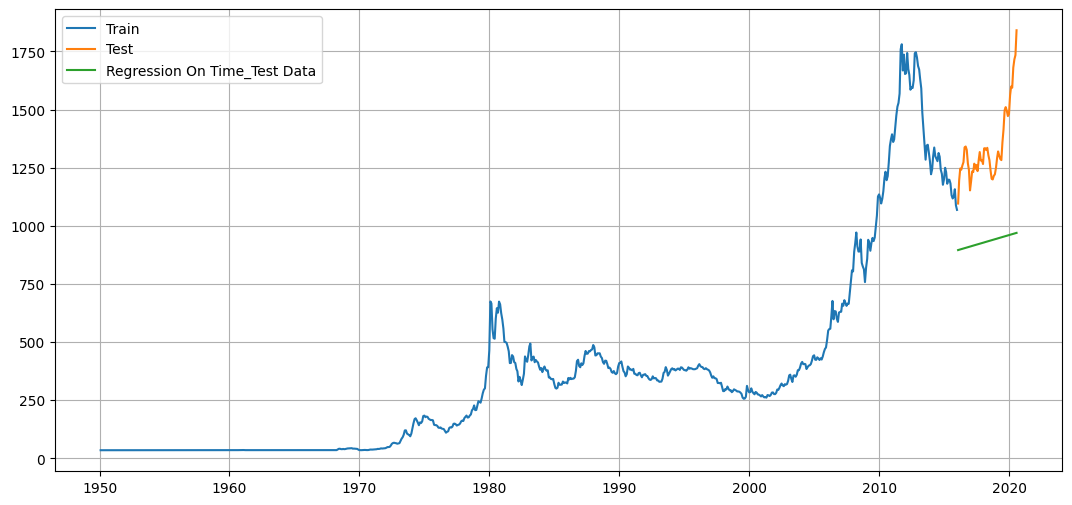

In [26]:
test_predictions_model1         = lr.predict(LR_test[['time']])
LR_test['forecast'] = test_predictions_model1

plt.figure(figsize=(13,6))
plt.plot( train['Price'], label='Train')
plt.plot(test['Price'], label='Test')
plt.plot(LR_test['forecast'], label='Regression On Time_Test Data')
plt.legend(loc='best')
plt.grid();

In [27]:
def mape(actual,pred):
    return round((np.mean(abs(actual-pred)/actual))*100,2)

In [28]:
# Get MAPE of the model

mape_model1_test = mape(test['Price'].values,test_predictions_model1)
print("For RegressionOnTime forecast on the Test Data,  MAPE is %3.3f" %(mape_model1_test),"%")

For RegressionOnTime forecast on the Test Data,  MAPE is 29.760 %


In [29]:
results = pd.DataFrame({'Test MAPE (%)': [mape_model1_test]},index=['RegressionOnTime'])
results

,Test MAPE (%)
RegressionOnTime,29.76


## Model 2 - Naive prediction <a class="anchor" id="section3.3"></a>

In [30]:
Naive_train = train.copy()
Naive_test = test.copy()

In [31]:
Naive_test['naive'] = np.asarray(train['Price'])[len(np.asarray(train['Price']))-1]
Naive_test['naive'].head()

month
2016-01-31    1068.317
2016-02-29    1068.317
2016-03-31    1068.317
2016-04-30    1068.317
2016-05-31    1068.317
Name: naive, dtype: float64

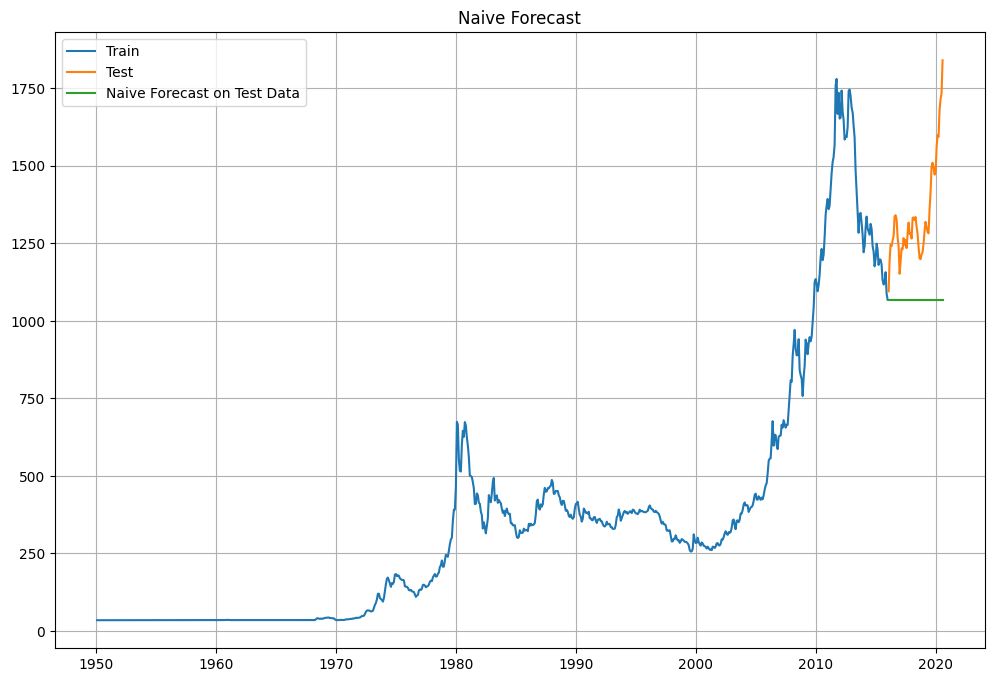

In [32]:
plt.figure(figsize=(12,8))
plt.plot(Naive_train['Price'], label='Train')
plt.plot(test['Price'], label='Test')
plt.plot(Naive_test['naive'], label='Naive Forecast on Test Data')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.grid();

In [33]:
# Get MAPE of the model

mape_model2_test = mape(test['Price'].values,Naive_test['naive'].values)
print("For Naive forecast on the Test Data,  MAPE is %3.3f" %(mape_model2_test),"%")

For Naive forecast on the Test Data,  MAPE is 19.380 %


In [34]:
resultsDf_2 = pd.DataFrame({'Test MAPE (%)': [mape_model2_test]},index=['NaiveModel'])

results = pd.concat([results, resultsDf_2])
results

,Test MAPE (%)
RegressionOnTime,29.76
NaiveModel,19.38


## Model 3 - Simple Average <a class="anchor" id="section3.4"></a>

In [35]:
SimpleAvg_train = train.copy()
SimpleAvg_test = test.copy()
SimpleAvg_test['mean_forecast'] = train['Price'].mean()
SimpleAvg_test.head()

,Price,mean_forecast
month,,
2016-01-31,1095.655,352.371841
2016-02-29,1194.893,352.371841
2016-03-31,1246.312,352.371841
2016-04-30,1241.452,352.371841
2016-05-31,1259.755,352.371841


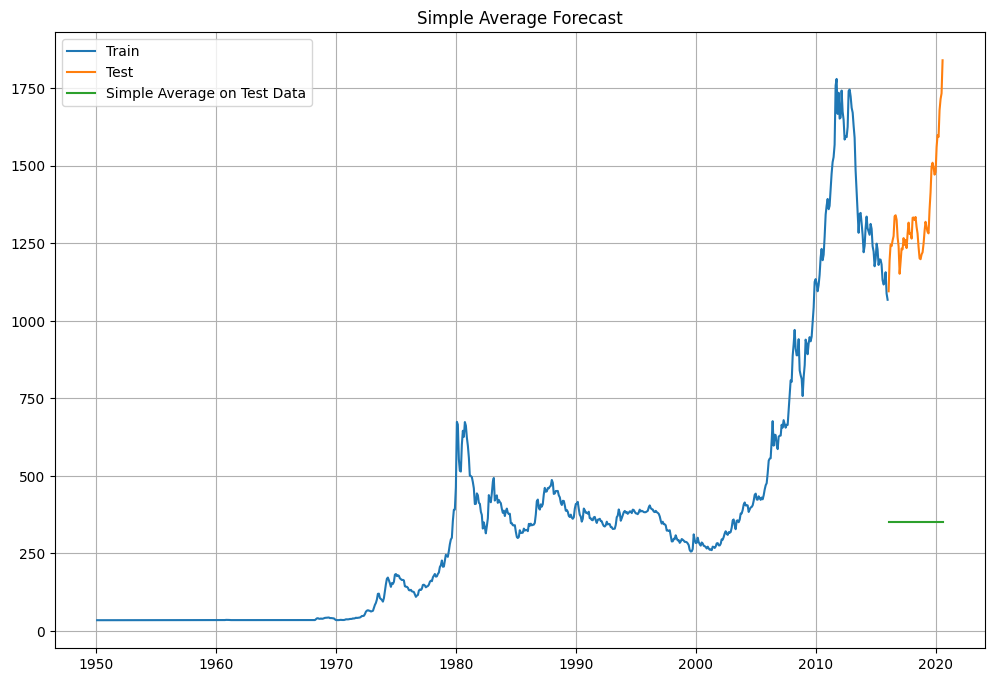

In [36]:
plt.figure(figsize=(12,8))
plt.plot(SimpleAvg_train['Price'], label='Train')
plt.plot(SimpleAvg_test['Price'], label='Test')
plt.plot(SimpleAvg_test['mean_forecast'], label='Simple Average on Test Data')
plt.legend(loc='best')
plt.title("Simple Average Forecast")
plt.grid();

In [37]:
## Test Data - MAPE

mape_model3_test = mape(test['Price'].values,SimpleAvg_test['mean_forecast'].values)
print("For Simple Average forecast on the Test Data,  MAPE is %3.3f" %(mape_model3_test),"%")

For Simple Average forecast on the Test Data,  MAPE is 73.410 %


In [38]:
resultsDf_3 = pd.DataFrame({'Test MAPE (%)': [mape_model3_test]},index=['SimpleAverageModel'])

results = pd.concat([results, resultsDf_3])
results

,Test MAPE (%)
RegressionOnTime,29.76
NaiveModel,19.38
SimpleAverageModel,73.41


## Model 4 - Moving Average <a class="anchor" id="section3.5"></a>

In [39]:
Mvg_Avg = df.copy()
Mvg_Avg['Trailing_2'] = Mvg_Avg['Price'].rolling(2).mean()
Mvg_Avg['Trailing_3'] = Mvg_Avg['Price'].rolling(3).mean()
Mvg_Avg['Trailing_5'] = Mvg_Avg['Price'].rolling(5).mean()
Mvg_Avg['Trailing_7'] = Mvg_Avg['Price'].rolling(7).mean()
Mvg_Avg.head()

,Price,Trailing_2,Trailing_3,Trailing_5,Trailing_7
month,,,,,
1950-01-31,34.73,NaN,NaN,NaN,NaN
1950-02-28,34.73,34.73,NaN,NaN,NaN
1950-03-31,34.73,34.73,34.73,NaN,NaN
1950-04-30,34.73,34.73,34.73,NaN,NaN
1950-05-31,34.73,34.73,34.73,34.73,NaN


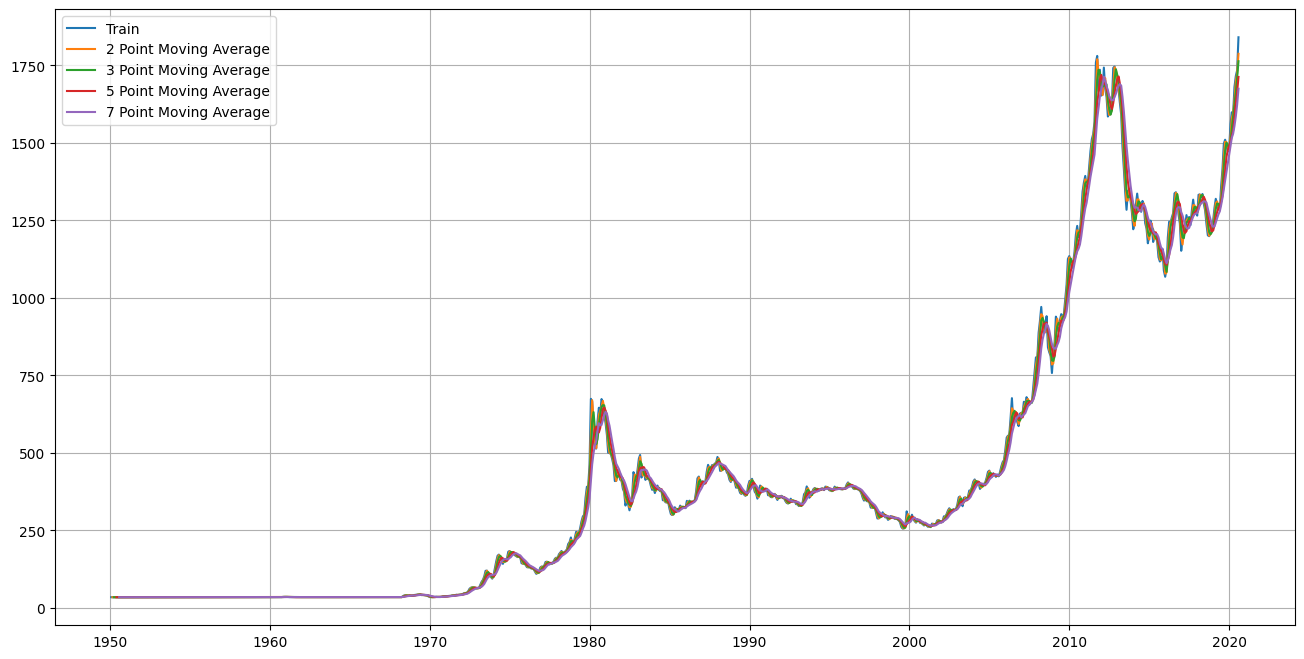

In [40]:
## Plotting on the whole data

plt.figure(figsize=(16,8))
plt.plot(Mvg_Avg['Price'], label='Train')
plt.plot(Mvg_Avg['Trailing_2'],label='2 Point Moving Average')
plt.plot(Mvg_Avg['Trailing_3'],label='3 Point Moving Average')
plt.plot(Mvg_Avg['Trailing_5'],label = '5 Point Moving Average')
plt.plot(Mvg_Avg['Trailing_7'],label = '7 Point Moving Average')

plt.legend(loc = 'best')
plt.grid();

In [41]:
#Creating train and test set 
trailing_Mvg_Avg_train=Mvg_Avg[Mvg_Avg.index.year <= 2015] 
trailing_Mvg_Avg_test=Mvg_Avg[Mvg_Avg.index.year > 2015]

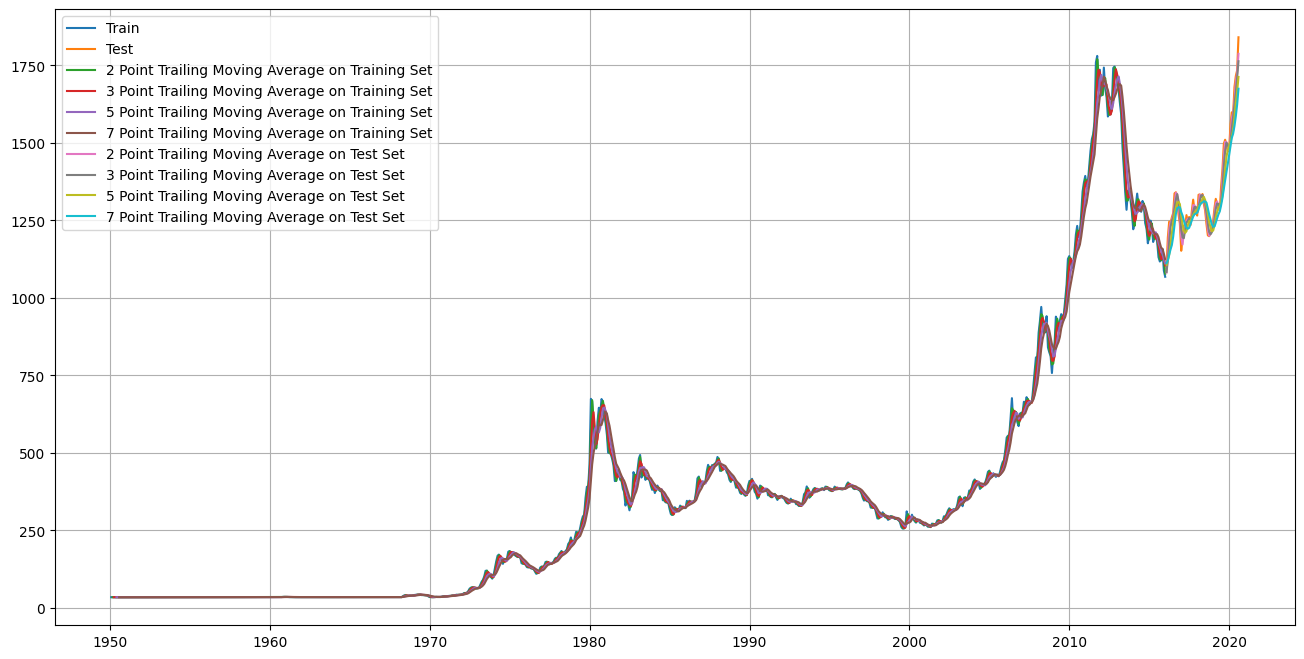

In [42]:
## Plotting on both the Training and Test data

plt.figure(figsize=(16,8))
plt.plot(trailing_Mvg_Avg_train['Price'], label='Train')
plt.plot(trailing_Mvg_Avg_test['Price'], label='Test')

plt.plot(trailing_Mvg_Avg_train['Trailing_2'],label='2 Point Trailing Moving Average on Training Set')
plt.plot(trailing_Mvg_Avg_train['Trailing_3'],label='3 Point Trailing Moving Average on Training Set')
plt.plot(trailing_Mvg_Avg_train['Trailing_5'],label = '5 Point Trailing Moving Average on Training Set')
plt.plot(trailing_Mvg_Avg_train['Trailing_7'],label = '7 Point Trailing Moving Average on Training Set')

plt.plot(trailing_Mvg_Avg_test['Trailing_2'], label='2 Point Trailing Moving Average on Test Set')
plt.plot(trailing_Mvg_Avg_test['Trailing_3'], label='3 Point Trailing Moving Average on Test Set')
plt.plot(trailing_Mvg_Avg_test['Trailing_5'],label = '5 Point Trailing Moving Average on Test Set')
plt.plot(trailing_Mvg_Avg_test['Trailing_7'],label = '7 Point Trailing Moving Average on Test Set')
plt.legend(loc = 'best')
plt.grid();

In [43]:
## Test Data - MAPE --> 2 point Trailing MA

mape_model4_test_2 = mape(test['Price'].values,trailing_Mvg_Avg_test['Trailing_2'].values)
print("For 2 point Moving Average Model forecast on the Training Data,  MAPE is %3.3f" %(mape_model4_test_2),"%")

## Test Data - MAPE  --> 3 point Trailing MA

mape_model4_test_3 = mape(test['Price'].values,trailing_Mvg_Avg_test['Trailing_3'].values)
print("For 3 point Moving Average Model forecast on the Training Data,  MAPE is %3.3f" %(mape_model4_test_3),"%")

## Test Data - MAPE --> 5 point Trailing MA

mape_model4_test_5 = mape(test['Price'].values,trailing_Mvg_Avg_test['Trailing_5'].values)
print("For 5 point Moving Average Model forecast on the Training Data,  MAPE is %3.3f" %(mape_model4_test_5),"%")

## Test Data - MAPE  --> 7 point Trailing MA

mape_model4_test_7 = mape(test['Price'].values,trailing_Mvg_Avg_test['Trailing_7'].values)
print("For 7 point Moving Average Model forecast on the Training Data,  MAPE is %3.3f " %(mape_model4_test_7),"%")

For 2 point Moving Average Model forecast on the Training Data,  MAPE is 1.230 %
For 3 point Moving Average Model forecast on the Training Data,  MAPE is 2.050 %
For 5 point Moving Average Model forecast on the Training Data,  MAPE is 3.330 %
For 7 point Moving Average Model forecast on the Training Data,  MAPE is 4.180  %


In [44]:
resultsDf_4 = pd.DataFrame({'Test MAPE (%)': [mape_model4_test_2,mape_model4_test_3
                                          ,mape_model4_test_5,mape_model4_test_7]}
                           ,index=['2pointTrailingMovingAverage','3pointTrailingMovingAverage'
                                   ,'5pointTrailingMovingAverage','7pointTrailingMovingAverage'])

results = pd.concat([results, resultsDf_4])
results

,Test MAPE (%)
RegressionOnTime,29.76
NaiveModel,19.38
SimpleAverageModel,73.41
2pointTrailingMovingAverage,1.23
3pointTrailingMovingAverage,2.05
5pointTrailingMovingAverage,3.33
7pointTrailingMovingAverage,4.18


### Model 5 - Simple Exponential Smoothing <a class="anchor" id="section3.6"></a>

In [45]:
SES_train = train.copy()
SES_test = test.copy()

In [46]:
model_SES = SimpleExpSmoothing(SES_train['Price'])
model_SES_autofit = model_SES.fit(optimized=True)

In [47]:
model_SES_autofit.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 34.73,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [48]:
SES_test['predict'] = model_SES_autofit.forecast(steps=len(test))
SES_test.head()

,Price,predict
month,,
2016-01-31,1095.655,1068.419069
2016-02-29,1194.893,1068.419069
2016-03-31,1246.312,1068.419069
2016-04-30,1241.452,1068.419069
2016-05-31,1259.755,1068.419069


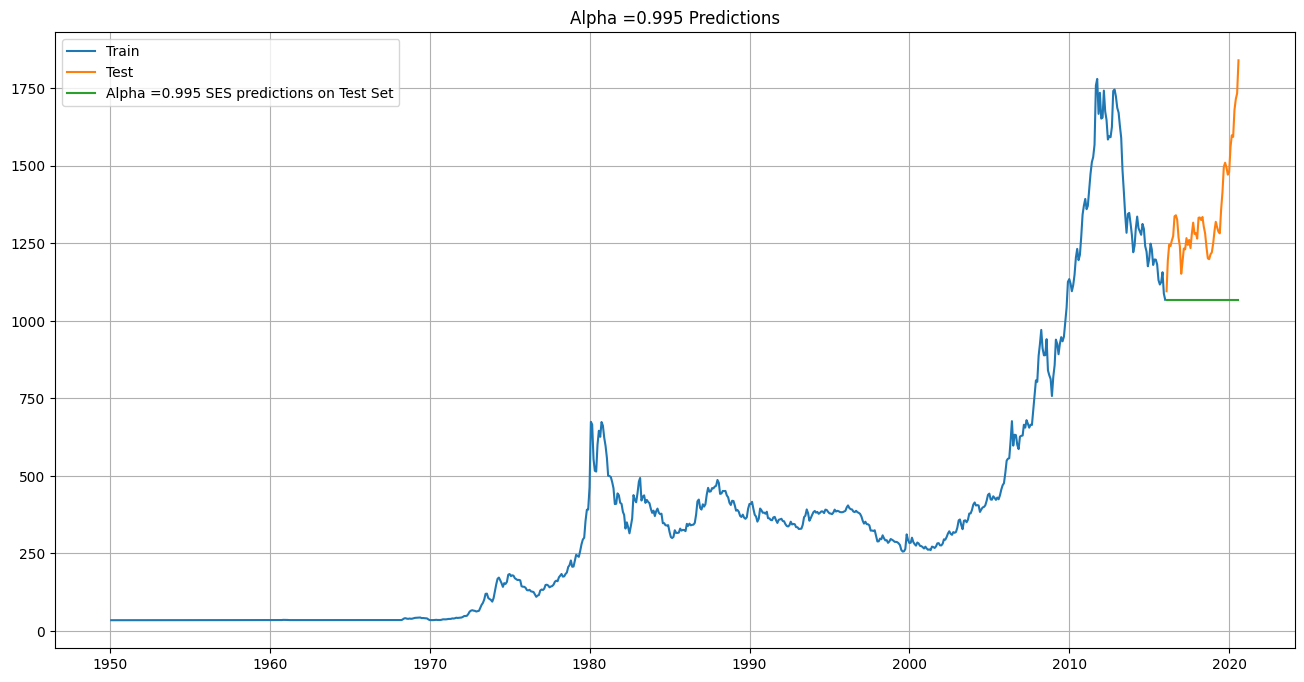

In [49]:
## Plotting on both the Training and Test data

plt.figure(figsize=(16,8))
plt.plot(SES_train['Price'], label='Train')
plt.plot(SES_test['Price'], label='Test')

plt.plot(SES_test['predict'], label='Alpha =0.995 SES predictions on Test Set')

plt.legend(loc='best')
plt.grid()
plt.title('Alpha =0.995 Predictions');

In [50]:
## Test Data

mape_model5_test_1 = mape(SES_test['Price'].values,SES_test['predict'].values)
print("For Alpha =0.995 SES Model forecast on the Test Data, MAPE is %3.3f" %(mape_model5_test_1),"%")

For Alpha =0.995 SES Model forecast on the Test Data, MAPE is 19.380 %


In [51]:
resultsDf_5 = pd.DataFrame({'Test MAPE (%)': [mape_model5_test_1]},index=['Alpha=0.995,SimpleExponentialSmoothing'])

results = pd.concat([results, resultsDf_5])
results

,Test MAPE (%)
RegressionOnTime,29.76
NaiveModel,19.38
SimpleAverageModel,73.41
2pointTrailingMovingAverage,1.23
3pointTrailingMovingAverage,2.05
5pointTrailingMovingAverage,3.33
7pointTrailingMovingAverage,4.18
"Alpha=0.995,SimpleExponentialSmoothing",19.38


In [57]:
resultsDf_6 = pd.DataFrame({'Alpha Values':[],'Train MAPE':[],'Test MAPE': []})

for i in np.arange(0.3,1,0.1):
    model_SES_alpha_i = model_SES.fit(smoothing_level=i,optimized=False,use_brute=True)
    SES_train['predict',i] = model_SES_alpha_i.fittedvalues
    SES_test['predict',i] = model_SES_alpha_i.forecast(steps=55)
    
    mape_model5_train_i = mape(SES_train['Price'].values,SES_train['predict',i].values)
    
    mape_model5_test_i = mape(SES_test['Price'].values,SES_test['predict',i].values)
    
    resultsDf_6.loc[len(resultsDf_6)] = {'Alpha Values':i,'Train MAPE':mape_model5_train_i ,'Test MAPE':mape_model5_test_i}

In [58]:
resultsDf_6.sort_values(by=['Test MAPE'],ascending=True)

,Alpha Values,Train MAPE,Test MAPE
0,0.3,4.02,16.03
1,0.4,3.45,16.92
2,0.5,3.11,17.57
3,0.6,2.87,18.09
4,0.7,2.71,18.53
5,0.8,2.58,18.89
6,0.9,2.47,19.18


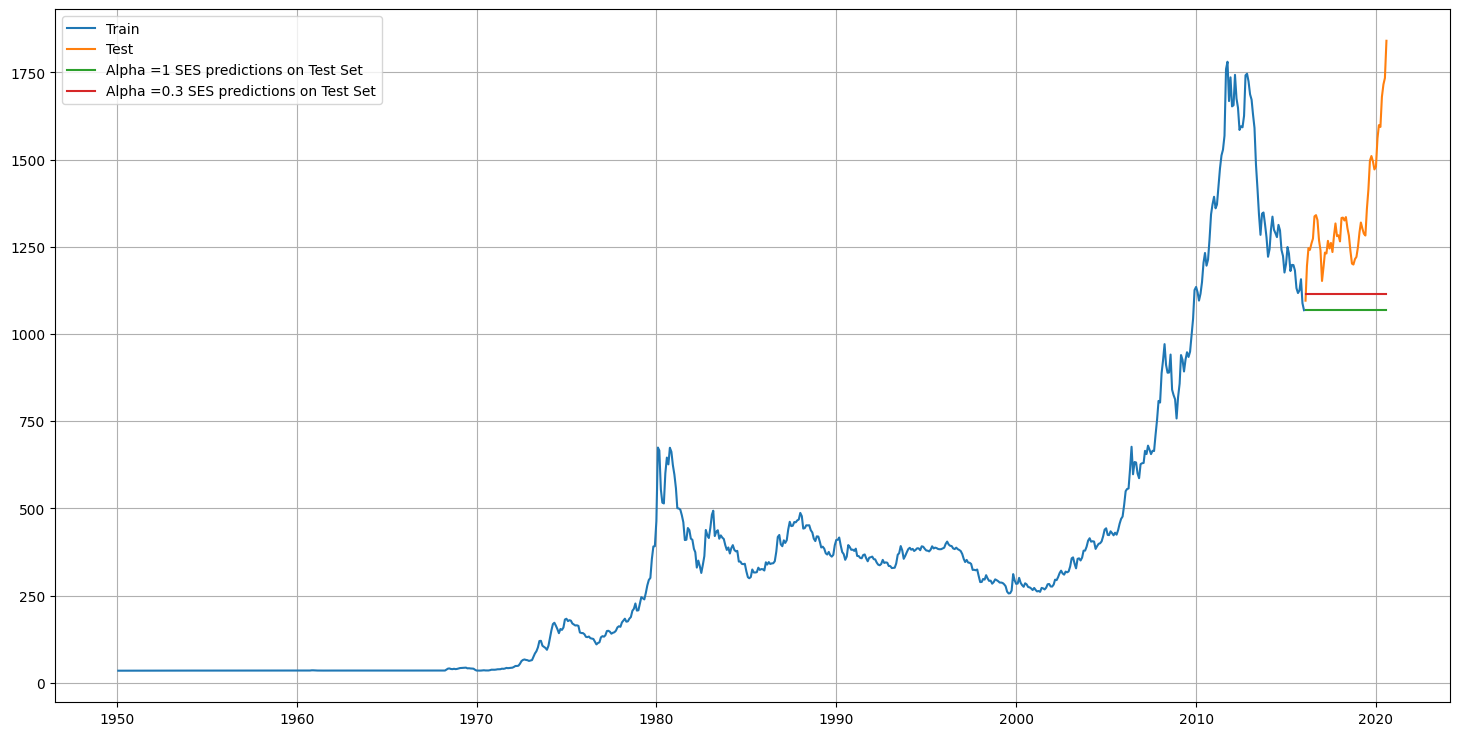

In [59]:
## Plotting on both the Training and Test data

plt.figure(figsize=(18,9))
plt.plot(SES_train['Price'], label='Train')
plt.plot(SES_test['Price'], label='Test')

plt.plot(SES_test['predict'], label='Alpha =1 SES predictions on Test Set')

plt.plot(SES_test['predict', 0.3], label='Alpha =0.3 SES predictions on Test Set')



plt.legend(loc='best')
plt.grid();

In [60]:
resultsDf_6_1 = pd.DataFrame({'Test MAPE (%)': [resultsDf_6.sort_values(by=['Test MAPE'],ascending=True).values[0][2]]}
                           ,index=['Alpha=0.3,SimpleExponentialSmoothing'])

results = pd.concat([results, resultsDf_6_1])
results

,Test MAPE (%)
RegressionOnTime,29.76
NaiveModel,19.38
SimpleAverageModel,73.41
2pointTrailingMovingAverage,1.23
3pointTrailingMovingAverage,2.05
5pointTrailingMovingAverage,3.33
7pointTrailingMovingAverage,4.18
"Alpha=0.995,SimpleExponentialSmoothing",19.38
"Alpha=0.3,SimpleExponentialSmoothing",16.03


## Model 6 - Double Exponential smoothing <a class="anchor" id="section3.7"></a>

In [61]:
DES_train = train.copy()
DES_test = test.copy()

In [62]:
model_DES = Holt(DES_train['Price'])

In [64]:
resultsDf_7 = pd.DataFrame({'Alpha Values':[],'Beta Values':[],'Train MAPE':[],'Test MAPE': []})

for i in np.arange(0.3,1.1,0.1):
    for j in np.arange(0.3,1.1,0.1):
        model_DES_alpha_i_j = model_DES.fit(smoothing_level=i,smoothing_trend=j,optimized=False,use_brute=True)
        DES_train['predict',i,j] = model_DES_alpha_i_j.fittedvalues
        DES_test['predict',i,j] = model_DES_alpha_i_j.forecast(steps=55)
        
        mape_model6_train = mape(DES_train['Price'].values,DES_train['predict',i,j].values)
        
        mape_model6_test = mape(DES_test['Price'].values,DES_test['predict',i,j].values)
        
        resultsDf_7.loc[len(resultsDf_7)]= {'Alpha Values':i,'Beta Values':j,'Train MAPE':mape_model6_train, 'Test MAPE':mape_model6_test}

In [65]:
resultsDf_7.sort_values(by=['Test MAPE']).head()

,Alpha Values,Beta Values,Train MAPE,Test MAPE
0,0.3,0.3,3.60,47.89
7,0.3,1.0,3.93,48.23
1,0.3,0.4,3.61,48.59
8,0.4,0.3,3.23,49.22
16,0.5,0.3,2.99,50.92


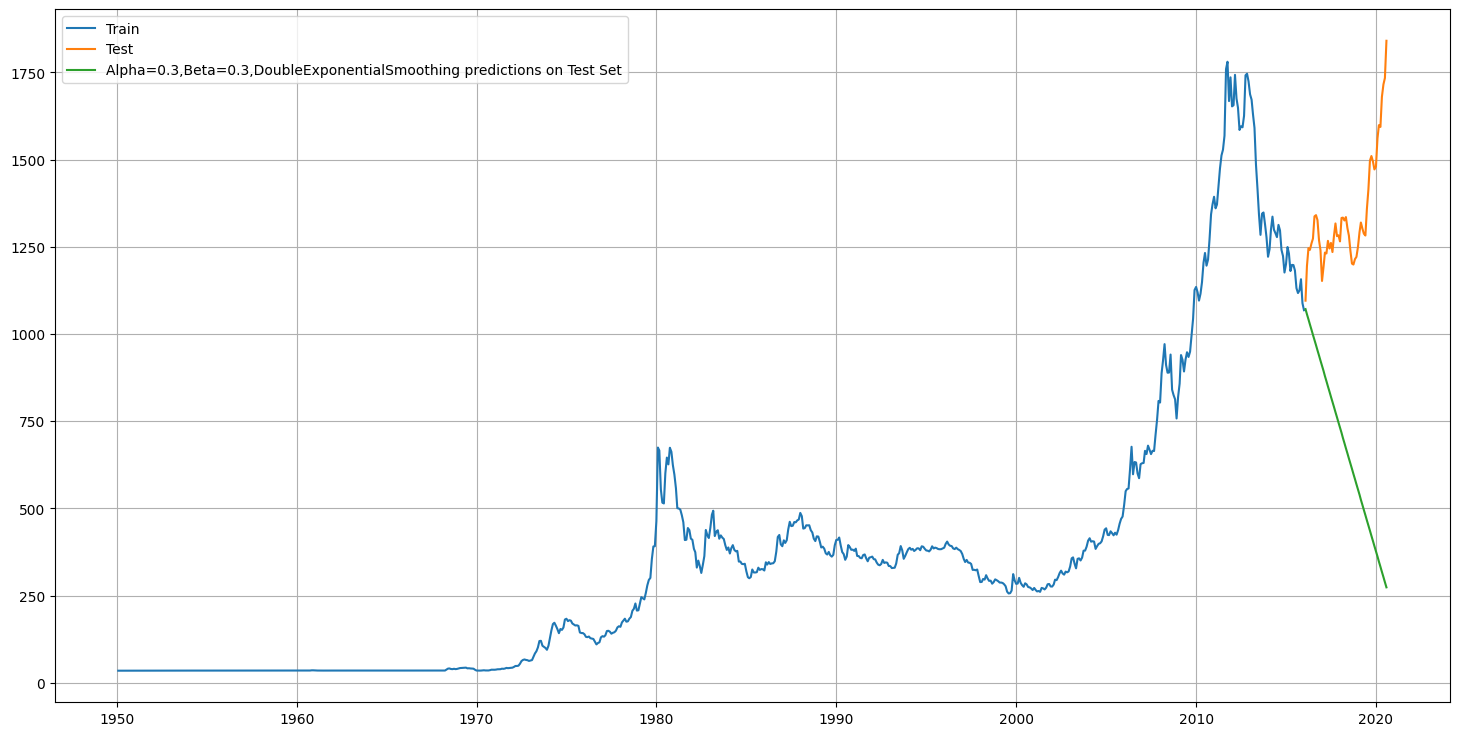

In [66]:
## Plotting on both the Training and Test data

plt.figure(figsize=(18,9))
plt.plot(DES_train['Price'], label='Train')
plt.plot(DES_test['Price'], label='Test')

plt.plot(DES_test['predict', 0.3, 0.3], label='Alpha=0.3,Beta=0.3,DoubleExponentialSmoothing predictions on Test Set')


plt.legend(loc='best')
plt.grid();

In [67]:
resultsDf_7_1 = pd.DataFrame({'Test MAPE (%)': [resultsDf_7.sort_values(by=['Test MAPE']).values[0][3]]}
                           ,index=['Alpha=0.3,Beta=0.3,DoubleExponentialSmoothing'])

results = pd.concat([results, resultsDf_7_1])
results

,Test MAPE (%)
RegressionOnTime,29.76
NaiveModel,19.38
SimpleAverageModel,73.41
2pointTrailingMovingAverage,1.23
3pointTrailingMovingAverage,2.05
5pointTrailingMovingAverage,3.33
7pointTrailingMovingAverage,4.18
"Alpha=0.995,SimpleExponentialSmoothing",19.38
"Alpha=0.3,SimpleExponentialSmoothing",16.03
"Alpha=0.3,Beta=0.3,DoubleExponentialSmoothing",47.89


## Model 7 - Triple Exponential Smoothing <a class="anchor" id="section3.8"></a>

In [68]:
TES_train = train.copy()
TES_test = test.copy()

In [69]:
model_TES = ExponentialSmoothing(TES_train['Price'],trend='additive',seasonal='additive',freq='M')
model_TES_autofit = model_TES.fit()

In [70]:
model_TES_autofit.params

{'smoothing_level': 0.9882650049836023,
 'smoothing_trend': 0.04330111199752529,
 'smoothing_seasonal': 0.00027777194103934075,
 'damping_trend': nan,
 'initial_level': 34.696616892614706,
 'initial_trend': -0.0006256708181916408,
 'initial_seasons': array([ 2.5039874 ,  4.36128596,  0.63955948, -0.99743837, -0.82265517,
        -2.40392822, -3.45115069, -1.70782781,  2.8071071 ,  1.98524897,
        -0.90351499, -2.04333077]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [71]:
## Prediction on the test data

TES_test['auto_predict'] = model_TES_autofit.forecast(steps=len(test))
TES_test.head()

,Price,auto_predict
month,,
2016-01-31,1095.655,1064.096947
2016-02-29,1194.893,1057.063498
2016-03-31,1246.312,1044.449173
2016-04-30,1241.452,1033.929375
2016-05-31,1259.755,1025.224197


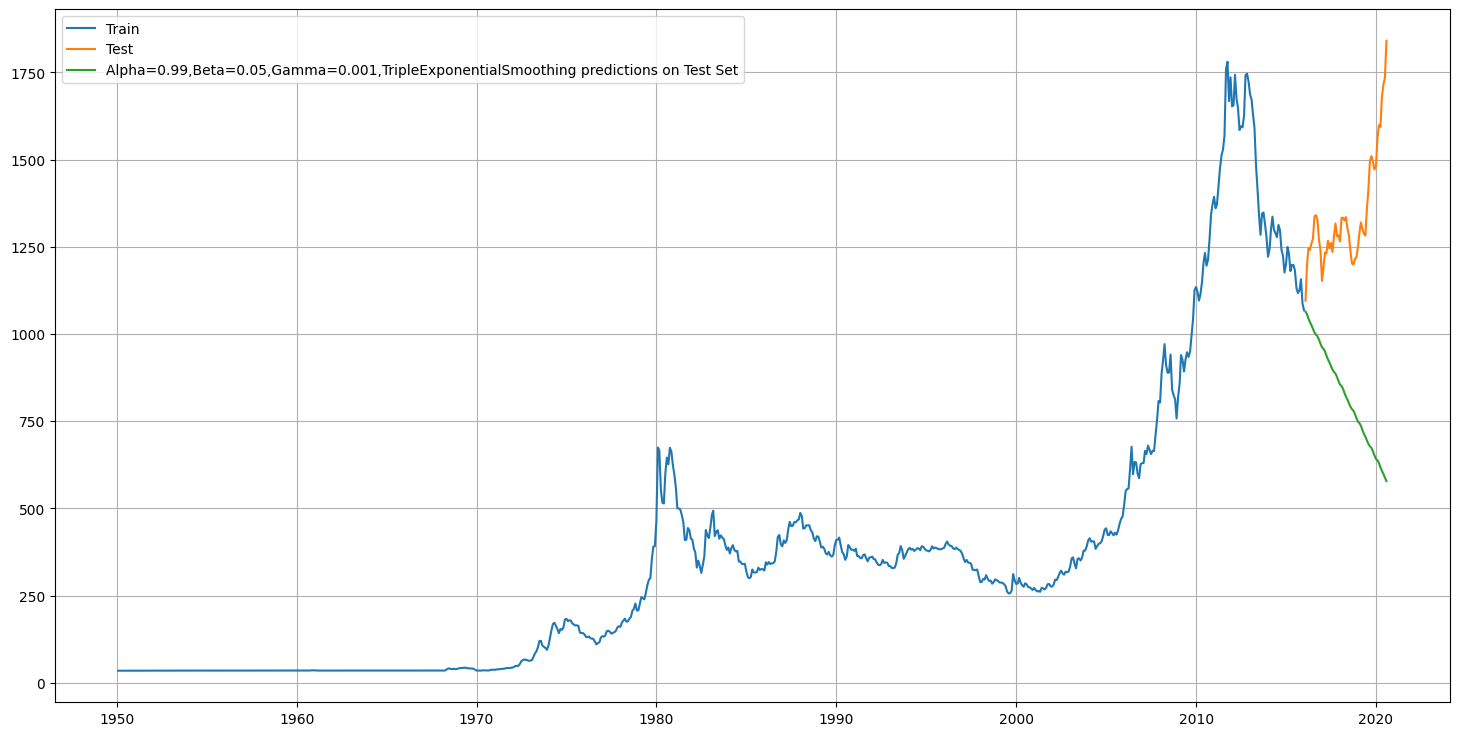

In [72]:
## Plotting on both the Training and Test using autofit

plt.figure(figsize=(18,9))
plt.plot(TES_train['Price'], label='Train')
plt.plot(TES_test['Price'], label='Test')

plt.plot(TES_test['auto_predict'], label='Alpha=0.99,Beta=0.05,Gamma=0.001,TripleExponentialSmoothing predictions on Test Set')


plt.legend(loc='best')
plt.grid();

In [73]:
## Test Data

mape_model6_test_1 = mape(TES_test['Price'].values,TES_test['auto_predict'].values)
print("For A=0.99,B=0.05,G=0.001, Triple ES Model forecast on the Test Data,  MAPE is %3.3f" %(mape_model6_test_1),"%")

For A=0.99,B=0.05,G=0.001, Triple ES Model forecast on the Test Data,  MAPE is 37.170 %


In [74]:
resultsDf_8_1 = pd.DataFrame({'Test MAPE (%)': [mape_model6_test_1]}
                           ,index=['Alpha=0.99,Beta=0.05,Gamma=0.001,TripleExponentialSmoothing'])

results = pd.concat([results, resultsDf_8_1])
results

,Test MAPE (%)
RegressionOnTime,29.76
NaiveModel,19.38
SimpleAverageModel,73.41
2pointTrailingMovingAverage,1.23
3pointTrailingMovingAverage,2.05
5pointTrailingMovingAverage,3.33
7pointTrailingMovingAverage,4.18
"Alpha=0.995,SimpleExponentialSmoothing",19.38
"Alpha=0.3,SimpleExponentialSmoothing",16.03
"Alpha=0.3,Beta=0.3,DoubleExponentialSmoothing",47.89


In [75]:
## First we will define an empty dataframe to store our values from the loop

resultsDf_8_2 = pd.DataFrame({'Alpha Values':[],'Beta Values':[],'Gamma Values':[],'Train MAPE':[],'Test MAPE': []})
resultsDf_8_2

,Alpha Values,Beta Values,Gamma Values,Train MAPE,Test MAPE


In [78]:
for i in np.arange(0.3,1.1,0.1):
    for j in np.arange(0.3,1.1,0.1):
        for k in np.arange(0.3,1.1,0.1):
            model_TES_alpha_i_j_k = model_TES.fit(smoothing_level=i,smoothing_trend=j,smoothing_seasonal=k,optimized=False,use_brute=True)
            TES_train['predict',i,j,k] = model_TES_alpha_i_j_k.fittedvalues
            TES_test['predict',i,j,k] = model_TES_alpha_i_j_k.forecast(steps=55)
        
            mape_model8_train = mape(TES_train['Price'].values,TES_train['predict',i,j,k].values)
            
            mape_model8_test = mape(TES_test['Price'].values,TES_test['predict',i,j,k].values)
            
            resultsDf_8_2.loc[len(resultsDf_8_2)] = {'Alpha Values':i,'Beta Values':j,'Gamma Values':k,'Train MAPE':mape_model8_train,'Test MAPE':mape_model8_test}

In [79]:
resultsDf_8_2.sort_values(by=['Test MAPE']).head()

,Alpha Values,Beta Values,Gamma Values,Train MAPE,Test MAPE
67,0.4,0.3,0.6,11.53,5.99
320,0.8,0.3,0.3,3.81,6.94
24,0.3,0.6,0.3,11.68,9.56
130,0.5,0.3,0.5,8.93,13.07
73,0.4,0.4,0.4,8.75,14.99


In [80]:
model_TES_alpha_best = model_TES.fit(smoothing_level=0.4,
                                      smoothing_trend=0.3,
                                      smoothing_seasonal=0.6,
                                      optimized=False,
                                      use_brute=True)
TES_train['predict',0.4,0.3,0.6] = model_TES_alpha_best.fittedvalues
TES_test['predict',0.4,0.3,0.6] = model_TES_alpha_best.forecast(steps=55)

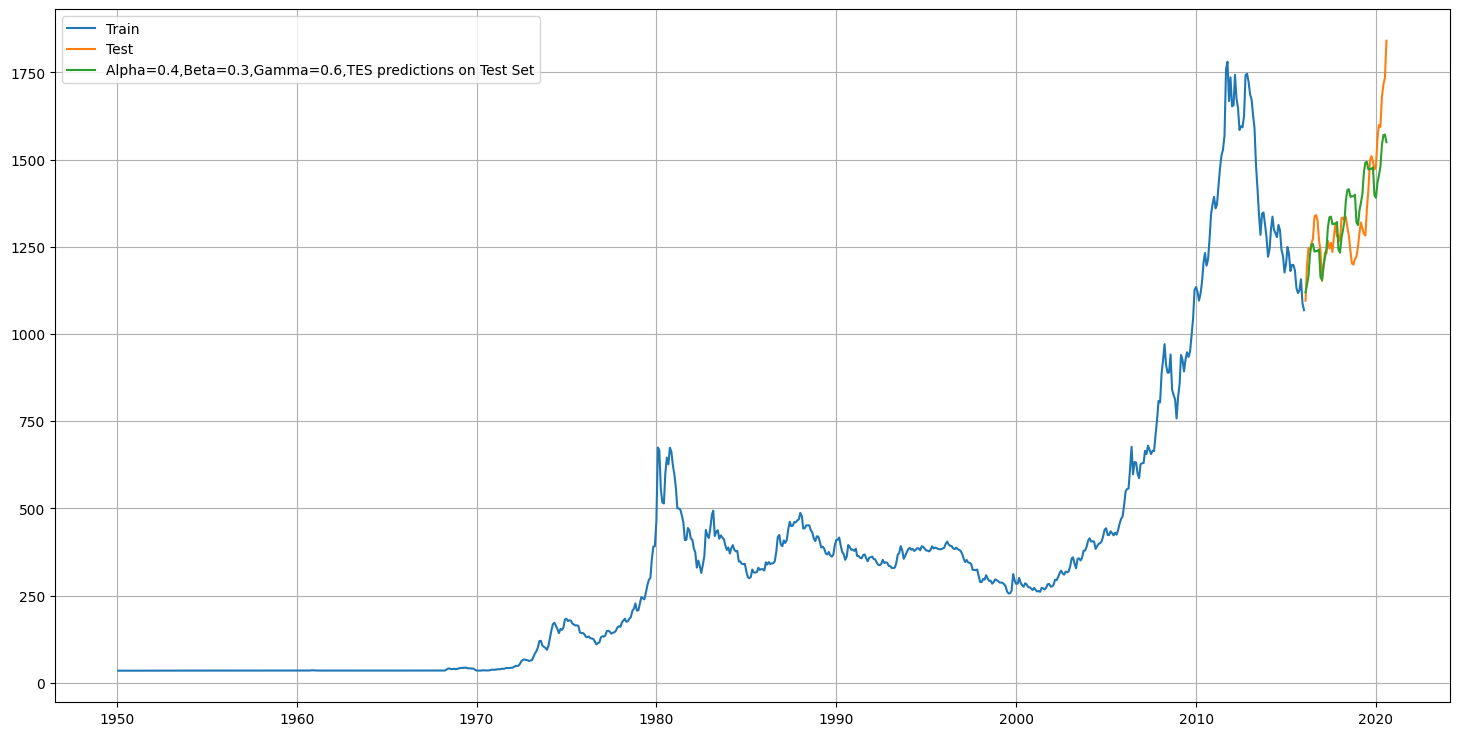

In [81]:
## Plotting on both the Training and Test data using brute force alpha, beta and gamma determination

plt.figure(figsize=(18,9))
plt.plot(TES_train['Price'], label='Train')
plt.plot(TES_test['Price'], label='Test')

#The value of alpha and beta is taken like that by python
plt.plot(TES_test['predict', 0.4, 0.3, 0.6], label='Alpha=0.4,Beta=0.3,Gamma=0.6,TES predictions on Test Set')


plt.legend(loc='best')
plt.grid();

In [82]:
## Test Data

mape_model7_test = mape(TES_test['Price'].values,TES_test['predict',0.4,0.3,0.6].values)
print("For A=0.4,B=0.3,G=0.6, Triple ES Model forecast on the Test Data,  MAPE is %3.3f" %(mape_model7_test),"%")

For A=0.4,B=0.3,G=0.6, Triple ES Model forecast on the Test Data,  MAPE is 5.990 %


In [83]:
resultsDf_9_1 = pd.DataFrame({'Test MAPE (%)': [mape_model7_test]}
                           ,index=['Alpha=0.4,Beta=0.3,Gamma=0.6,TripleExponentialSmoothing'])

results = pd.concat([results, resultsDf_9_1])
results

,Test MAPE (%)
RegressionOnTime,29.76
NaiveModel,19.38
SimpleAverageModel,73.41
2pointTrailingMovingAverage,1.23
3pointTrailingMovingAverage,2.05
5pointTrailingMovingAverage,3.33
7pointTrailingMovingAverage,4.18
"Alpha=0.995,SimpleExponentialSmoothing",19.38
"Alpha=0.3,SimpleExponentialSmoothing",16.03
"Alpha=0.3,Beta=0.3,DoubleExponentialSmoothing",47.89


# Final Model <a class="anchor" id="section4"></a>

In [84]:
final_model =  ExponentialSmoothing(df,
                                  trend='additive',
                                  seasonal='additive').fit(smoothing_level=0.4,
                                                           smoothing_trend=0.3,
                                                           smoothing_seasonal=0.6)

In [85]:
MAPE_final_model = mape(df['Price'].values,final_model.fittedvalues)

print('MAPE:',MAPE_final_model)

MAPE: 17.24


In [86]:
# Getting the predictions for the same number of times stamps that are present in the test data
prediction = final_model.forecast(steps=len(test))

In [87]:
# Compute 95% confidence interval for predicted values
pred_df = pd.DataFrame({'lower_CI':prediction - 1.96*np.std(final_model.resid,ddof=1),
                        'prediction':prediction,
                        'upper_CI': prediction + 1.96*np.std(final_model.resid,ddof=1)})
pred_df.head()

,lower_CI,prediction,upper_CI
2020-08-31,1684.720065,1792.871037,1901.022009
2020-09-30,1615.306077,1723.457050,1831.608022
2020-10-31,1538.567922,1646.718895,1754.869867
2020-11-30,1476.758600,1584.909572,1693.060545
2020-12-31,1459.327290,1567.478262,1675.629235


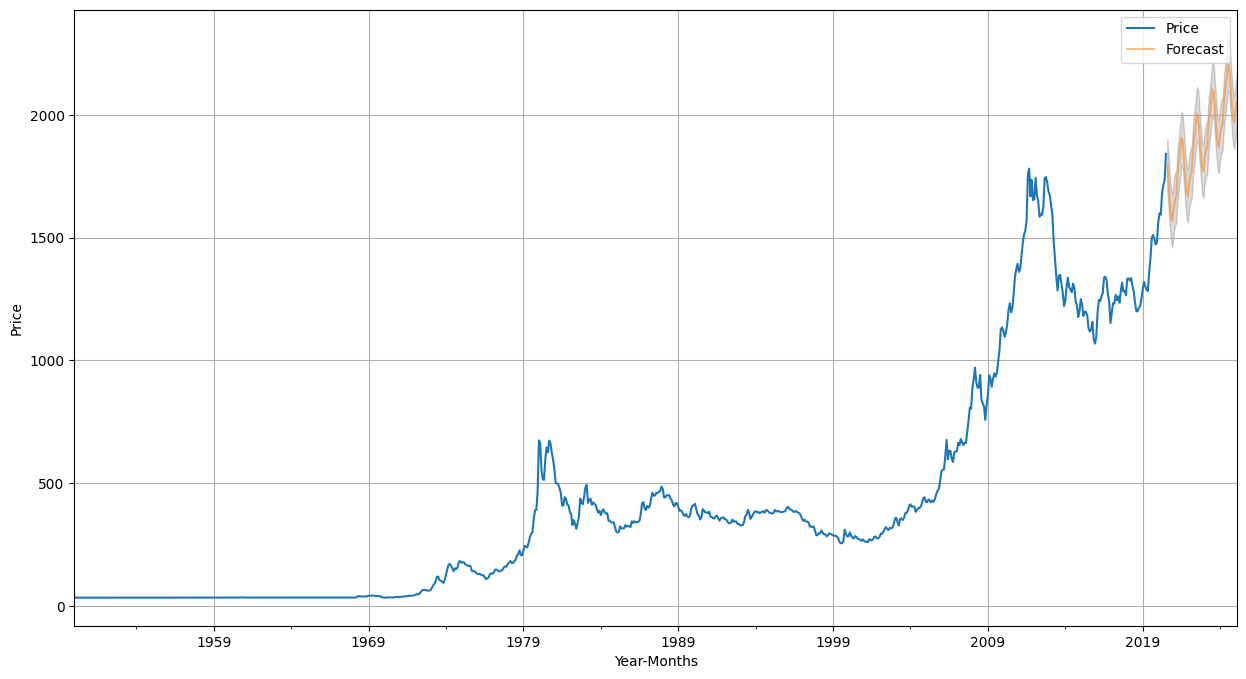

In [88]:
# plot the forecast along with the confidence band

axis = df.plot(label='Actual', figsize=(15,8))
pred_df['prediction'].plot(ax=axis, label='Forecast', alpha=0.5)
axis.fill_between(pred_df.index, pred_df['lower_CI'], pred_df['upper_CI'], color='k', alpha=.15)
axis.set_xlabel('Year-Months')
axis.set_ylabel('Price')
plt.legend(loc='best')
plt.grid()
plt.show()